### Imports

In [ ]:
# install requirements
!pip install torchvision>=0.3.0
!pip install pretrainedmodels==0.7.4
!pip install segmentation_models_pytorch
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=a25e133558cf4dc78fb607d9dcc40e03db920b850704ef5cc65ba2a816896ec0
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.1-cp36-none-any.whl size=12410 sha256=74cf70c7133b816ddaca12bdb3e6950740d79bf7d1ca228d6256736def6195e3
  Stored in directory: /root/.cache/pip/wheels/0f/b0/79/1663bc9714b5d88deba05e44f593ce50111bd69305a45df87a
Successfully built efficientnet-pytorch
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ubahc3jm
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ubahc3jm
     |████████████████████████████████| 634kB 2.8MB/s 
  Created wheel for

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
import shutil
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2
import albumentations as albu
import torch
import torch.nn as nn
from PIL import Image, ImageDraw
from albumentations.pytorch import ToTensor
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

###Prepare data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# unzip the datasets
!unzip /content/drive/My\ Drive/p\ ImageBlending\ -\ ресурсы/Window_view/datasets/insta_100_images_dataset_with_new_masks.zip

unzip:  cannot find or open /content/drive/My Drive/p ImageBlending - ресурсы/Window_view/datasets/insta_100_images_dataset_with_new_masks.zip, /content/drive/My Drive/p ImageBlending - ресурсы/Window_view/datasets/insta_100_images_dataset_with_new_masks.zip.zip or /content/drive/My Drive/p ImageBlending - ресурсы/Window_view/datasets/insta_100_images_dataset_with_new_masks.zip.ZIP.


In [ ]:
!unzip insta_100_images_dataset_with_new_masks.zip

Archive:  insta_100_images_dataset_with_new_masks.zip
   creating: insta_100_images_dataset_with_new_masks/
   creating: insta_100_images_dataset_with_new_masks/images/
  inflating: insta_100_images_dataset_with_new_masks/images/2013-09-29 09.46.39 555409553222055833_lookingthroughwindow.jpg  
  inflating: insta_100_images_dataset_with_new_masks/images/2013-12-23 08.27.40 616975728757237436_lookingthroughwindow.jpg  
  inflating: insta_100_images_dataset_with_new_masks/images/2014-04-25 06.26.09 706061989668504925_lookingthroughwindow.jpg  
  inflating: insta_100_images_dataset_with_new_masks/images/2015-01-16 18.46.54 899225162260011133_lookingthroughwindow.jpg  
  inflating: insta_100_images_dataset_with_new_masks/images/2015-07-12 21.20.58 1027588007703343893_lookingthroughwindow.jpg  
  inflating: insta_100_images_dataset_with_new_masks/images/2015-09-09 01.59.52 1069765378192446164_windowviews.jpg  
  inflating: insta_100_images_dataset_with_new_masks/images/2016-07-25 16.37.58 13

In [ ]:
# create common folder for dataset
!mkdir /content/dataset/
!mkdir /content/dataset/train
!mkdir /content/dataset/val
!mkdir /content/dataset/test
!mkdir /content/dataset/train/images
!mkdir /content/dataset/val/images
!mkdir /content/dataset/test/images
!mkdir /content/dataset/train/masks
!mkdir /content/dataset/val/masks
!mkdir /content/dataset/test/masks

In [ ]:
# folder list
list_folders = [
                'insta_100_images_dataset_with_new_masks'
                ]

# cycle by folders
for folder in list_folders:
  list_images = os.listdir(os.path.join('/content/', folder, 'images'))
  random.shuffle(list_images)
  length = len(list_images)
  train = list_images[:int(0.8 * length)]
  val   = list_images[int(0.8 * length):int(0.9 * length)]
  test  = list_images[int(0.9 * length):]  
  for im in train:
    shutil.copyfile(os.path.join('/content', folder, 'images', im), os.path.join('/content/dataset/train/images', folder+im))
    shutil.copyfile(os.path.join('/content', folder, 'masks', im), os.path.join('/content/dataset/train/masks', folder+im))
  for im in val:
    shutil.copyfile(os.path.join('/content', folder, 'images', im), os.path.join('/content/dataset/val/images', folder+im))
    shutil.copyfile(os.path.join('/content', folder, 'masks', im), os.path.join('/content/dataset/val/masks', folder+im))
  for im in test:
    shutil.copyfile(os.path.join('/content', folder, 'images', im), os.path.join('/content/dataset/test/images', folder+im))
    shutil.copyfile(os.path.join('/content', folder, 'masks', im), os.path.join('/content/dataset/test/masks', folder+im))

### Define the model

In [ ]:
def get_training_augmentation():
  train_transform = [
      albu.Resize(256, 256),
      albu.HorizontalFlip(p=0.5),

      albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0, shift_limit=0.03, p=0.5, border_mode=0),

      # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
      # albu.RandomCrop(height=320, width=320, always_apply=True),

      # albu.IAAAdditiveGaussianNoise(p=0.2),
      # albu.IAAPerspective(p=0.5),

      # albu.OneOf(
      #     [
              # albu.CLAHE(p=1),
              # albu.RandomBrightness(p=1),
              # albu.RandomGamma(p=1),
      #     ],
      #     p=0.9,
      # ),

      # albu.OneOf(
      #     [
              # albu.IAASharpen(p=1),
              # albu.Blur(blur_limit=3, p=1),
              # albu.MotionBlur(blur_limit=3, p=1),
      #     ],
      #     p=0.9,
      # ),

      # albu.OneOf(
      #     [
              # albu.RandomContrast(p=1),
              # albu.HueSaturationValue(p=1),
          # ],
          # p=0.9,
      # ),
      albu.Normalize(),
  ]
  return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
          albu.Resize(256, 256),
          albu.Normalize()
          # albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
class Dataset(BaseDataset):
  def __init__(
      self, 
      images_dir, 
      masks_dir, 
      augmentation=None, 
      preprocessing=None,
  ):
    self.names = os.listdir(images_dir)
    self.images_paths = [os.path.join(images_dir, name) for name in self.names]
    self.masks_paths = [os.path.join(masks_dir, name) for name in self.names]
    self.augmentation = augmentation
    self.preprocessing = preprocessing
    
  def __getitem__(self, i):
      # read data
      image = cv2.imread(self.images_paths[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(self.masks_paths[i], 0)
      # mask = mask.astype('float')
      mask = np.clip(mask,0,1)
      mask = np.expand_dims(mask, axis=2)

              
      # apply augmentations
      if self.augmentation:
          sample = self.augmentation(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']
      
      # apply preprocessing
      if self.preprocessing:
          sample = self.preprocessing(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']
          
      return image, mask
      
  def __len__(self):
      return len(self.names)

In [ ]:
# Lets look at data we have
x_train_dir = '/content/dataset/train/images'
y_train_dir = '/content/dataset/train/masks'

x_valid_dir = '/content/dataset/val/images'
y_valid_dir = '/content/dataset/val/masks'

x_test_dir = '/content/dataset/test/images'
y_test_dir = '/content/dataset/test/masks'

dataset = Dataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


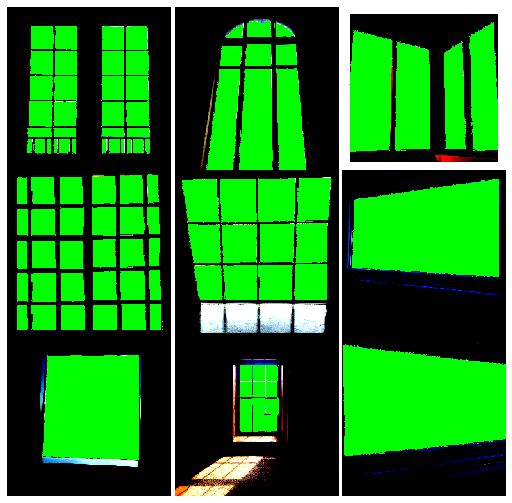

In [ ]:
h,w = 3,3

fig,ax = plt.subplots(h,w,figsize=(9,round((9/w)*h)))
for i in range(h*w):
  image, mask = dataset[i]
  ax[(i)%h][i//w].set_xticklabels([])
  ax[(i)%h][i//w].set_yticklabels([])
  ax[(i)%h][i//w].axis('off')
  mask = mask.squeeze()
  image[mask!=0] = (0,255,0)
  ax[(i)%h][i//w].imshow(image)
  
plt.subplots_adjust(wspace=0, hspace=0)
fig.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1,
    activation='sigmoid'
)
model.to(device)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [ ]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score

class DiceLoss(nn.Module):
  __name__ = 'dice_loss'

  def __init__(self, eps=1e-7, activation='sigmoid'):
      super().__init__()
      self.activation = activation
      self.eps = eps

  def forward(self, y_pr, y_gt):
      return 1 - f_score(y_pr, y_gt, beta=1., eps=self.eps, threshold=None, activation=self.activation)


class BCEDiceLoss(DiceLoss):
  __name__ = 'bce_dice_loss'

  def __init__(self, eps=1e-7, activation='sigmoid'):
      super().__init__(eps, activation)
      self.bce = nn.BCEWithLogitsLoss(reduction='mean')

  def forward(self, y_pr, y_gt):
      dice = super().forward(y_pr, y_gt)
      bce = self.bce(y_pr, y_gt)
      return dice + bce

In [ ]:
loss = BCEDiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.99)

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 200):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    if i == 100:
        optimizer.param_groups[0]['lr'] = 1e-7
        print('Decrease decoder learning rate to 1e-6!')


Epoch: 0
valid: 100%|██████████| 10/10 [00:00<00:00, 23.67it/s, bce_dice_loss - 1.262, iou_score - 0.6242]
Model saved!

Epoch: 1
valid: 100%|██████████| 10/10 [00:00<00:00, 22.86it/s, bce_dice_loss - 1.349, iou_score - 0.4479]

Epoch: 2
valid: 100%|██████████| 10/10 [00:00<00:00, 23.21it/s, bce_dice_loss - 1.21, iou_score - 0.6691]
Model saved!

Epoch: 3
valid: 100%|██████████| 10/10 [00:00<00:00, 22.76it/s, bce_dice_loss - 1.19, iou_score - 0.6716]
Model saved!

Epoch: 4
valid: 100%|██████████| 10/10 [00:00<00:00, 22.84it/s, bce_dice_loss - 1.311, iou_score - 0.1151]

Epoch: 5
valid: 100%|██████████| 10/10 [00:00<00:00, 23.68it/s, bce_dice_loss - 1.238, iou_score - 0.4126]

Epoch: 6
valid: 100%|██████████| 10/10 [00:00<00:00, 23.83it/s, bce_dice_loss - 1.181, iou_score - 0.6285]

Epoch: 7
valid: 100%|██████████| 10/10 [00:00<00:00, 19.69it/s, bce_dice_loss - 1.314, iou_score - 0.2338]

Epoch: 8
valid: 100%|██████████| 10/10 [00:00<00:00, 21.50it/s, bce_dice_loss - 1.386, iou_score -

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=device,
)

logs = test_epoch.run(test_loader)

valid: 100%|██████████| 10/10 [00:00<00:00, 19.90it/s, bce_dice_loss - 1.188, iou_score - 0.7947]


In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir
)

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

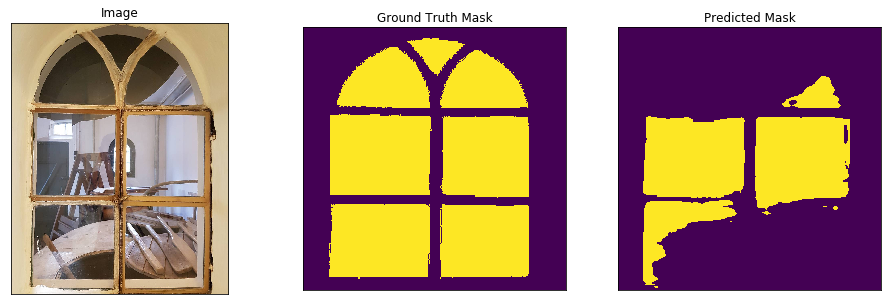

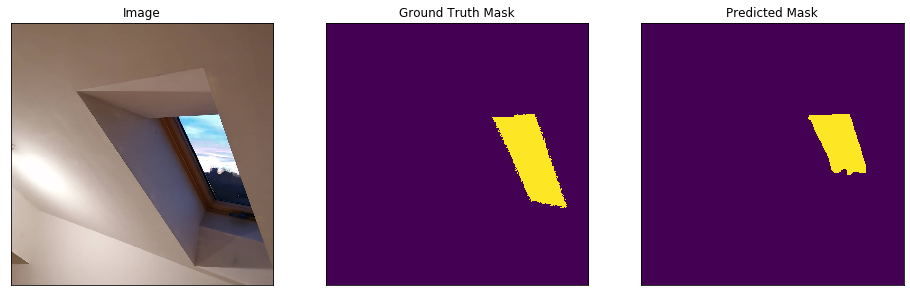

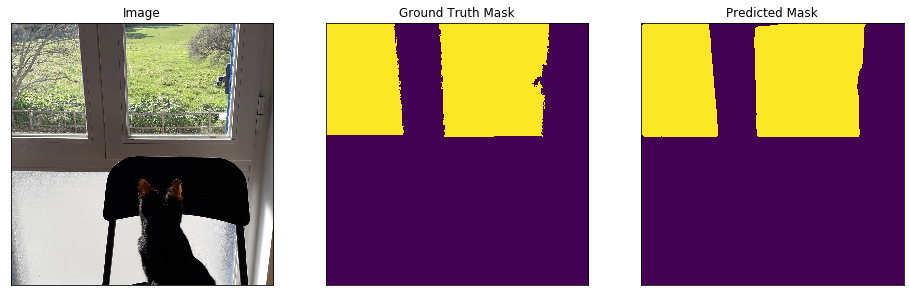

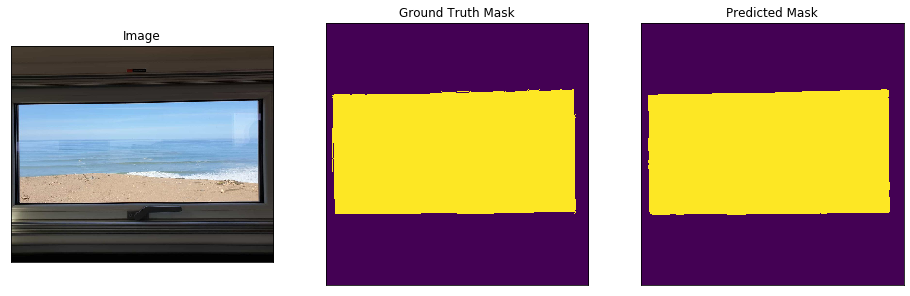

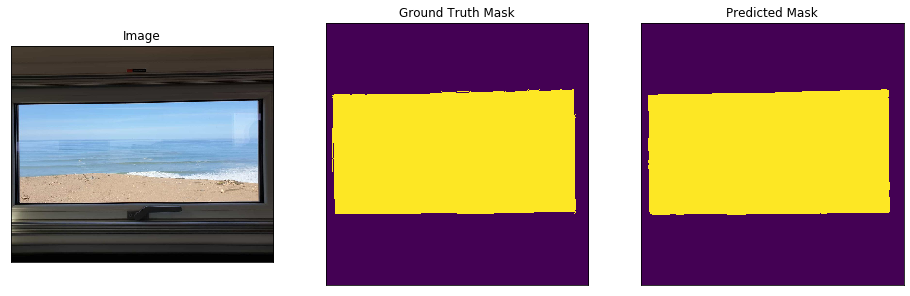

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    mask = model.predict(x_tensor)
    mask = (mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=mask
    )